In [1]:
import numpy as np
from hamiltonian import Hamiltonian
from matplotlib import pyplot as plt
from potentials import *
from scipy.integrate import simps
import tqdm
from cranknicolson import run_CN
from IPython.display import HTML
import matplotlib.animation as animation

# The Schrödinger equation

The time-dependent Schrödinger equation (TDSE) is given by
\begin{equation}    
    i\hbar \dot{\Psi}(\mathbf{r}, t) = \hat{H}(\mathbf{r},t)\Psi(\mathbf{r},t),
\end{equation}
where $\hat{H}(t)$ is the Hamiltonian of the system.   
Given an initial wavefunction
\begin{equation}
\Psi(\mathbf{r},t=0) = \Psi_0,
\end{equation}
the TDSE determines the wavefunction for some future time $t$. 

Generally, for a $N$-particle system, the wavefunction is a function of all $N$-coordinates, 
$\Psi(\mathbf{r}) = \Psi(r_1,r_2,\cdots,r_N)$.  

In the forthcoming, we restrict our attention to a single particle moving in one dimension.

The Hamiltonian of a single particle confined by a potential $V(x)$ is, in [atomic units][1] ($\hbar = m_e = e = 1$),  given by 
\begin{equation}
\hat{H}(x) = -\frac{1}{2}\frac{d^2}{dx^2} + V(x).
\end{equation}

[1]:https://en.wikipedia.org/wiki/Atomic_units

Following Ref.[1], when the potential $V(x)$ is time-independent we can use separation of variables 
\begin{equation}
\Psi(x,t) = \psi_n(x) \varphi(t),
\end{equation}
and insertion into the TDSE yields
\begin{align}
\frac{d}{dt}\varphi(t) &= -iE_n\varphi(t) \Rightarrow \varphi(t) = e^{-iE_nt}, \ \ (1) \\
\left( -\frac{1}{2}\frac{d^2 }{dx^2} + V(x)\right) \psi_n(x) &= E\psi_n(x), \ \ n=1,2,3,\cdots \ \ \ \ \ \ \ (2)
\end{align}
with the total wavefunction given by
\begin{equation}
\Psi(x,t) = \psi_n(x)e^{-iE_nt}.
\end{equation}

Eq.(2) is the time-independent Schrödinger equation (TISE) which is an eigenvalue problem. Its solutions, the eigenvalues $\{ E_n \}$ and eigenfunctions $\{ \psi_n(x) \}$, are what we refer to as the energy states or eigenstates of the system given by the Hamiltonian. In particular, the state with lowest energy is what we refer to as the groundstate of the system.

* Typical choice for the initial state is the ground state or some low-lying excited state
* Solving the TISE is in itself an active field of research. It is the equation most researcher in the field 
are working with.
    - Hartree-Fock
    - DFT
    - Coupled-cluster
    - VMC
    - Configuration interaction


Moreover, the eigenstates are stationary states in the sense that the probability density
\begin{equation}
|\Psi(x,t)|^2 = \Psi^*(x,t)\Psi(x,t) = \psi_n^*(x)e^{iE_nt}e^{-iE_nt}\psi_n(x) = |\psi_n(x)|^2,
\end{equation}
is independent of time.

Now, if the initial state is a superposition of eigenstates
\begin{equation}
\Psi_0 = \sum_{n=1} c_n \psi_n(x), \ \ \sum_{n=1}|c_n|^2 = 1,
\end{equation}
the solution to the TDSE is given by
\begin{equation}
\Psi(x,t) = c_n e^{-iE_nt}\psi_n(x).
\end{equation}
For example,
\begin{equation}
\Psi(x,t) = c_1 e^{-iE_1t}\psi_1(x) + c_2 e^{-iE_2t}\psi_2(x),
\end{equation}
the probability density oscillates in time between the two states,
\begin{equation}
|\Psi(x,t)|^2 = c_1^2 \psi_1^2(x) + c_2^2 \psi_2^2(x) + 2c_1c_2 \psi_1(x)\psi_2(x) \cos[(E_2-E_1)t].
\end{equation}

[1]: Introduction to Quantum Mechanics by David J. Griffiths

# Discretization

* We will develop a program for solving the TDSE on a one-dimensional grid
   
We consider an interval $x \in [-L, L]$. With a uniform discretization of the domain, the grid/mesh points are given by
\begin{equation}
x_i = x_0+i\Delta x, \ \ i=0,1,2\cdots,N_x+1,
\end{equation}
where $x_0 = -L, x_{N_x+1} = L$, $\Delta x$ is the grid spacing/step-length and $N_x$ is the number of (interior grid points).

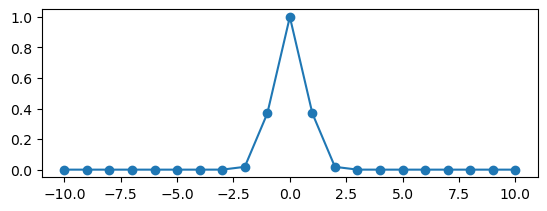

In [2]:
L = 10
delta_x = 1.0
N_x = int(2*L/delta_x)
x = np.zeros(N_x+1)

x0 = -L
for i in range(N_x+1):
    x[i] = x0 + i*delta_x
    
plt.figure()
plt.subplot(211)
plt.plot(x, np.exp(-x**2), '-o')
plt.show()

For the double derivative we use the three-point finite difference approximation, which is valid for the interior grid points, and is given by
\begin{align}
\frac{d^2}{dx^2}\psi(x)|_{x=x_i} &\approx \frac{\psi(x_i-\Delta x)-2\psi(x_i)+\psi(x_i+\Delta x)}{\Delta x^2} + \mathcal{O}(\Delta x^2) \\
&= \frac{\psi_{i-1}-2\psi_i+\psi_{i+1}}{\Delta x^2} + \mathcal{O}(\Delta x^2), \ \ i=1,\cdots,N_x,
\end{align}
where we have defined $\psi(x_i) \equiv \psi_i$. Also, we assume that wavefunction goes to zero at the end points such that $\psi_0 = \psi_{N_x+1} = 0$.

This allows us to approximate the action of the Hamiltonian on a wavefunction as
\begin{align}
\hat{H}\psi(x_i) &= -\frac{1}{2}\frac{d^2}{dx^2}\psi(x)|_{x=x_i}+V(x_i)\psi(x_i) \\
               &\approx -\frac{1}{2}\left(\frac{\psi_{i-1}-2\psi_i+\psi_{i+1}}{\Delta x^2}\right) + V(x_i)\psi_i. 
\end{align}

This can be written on matrix form as
\begin{equation}
H\vec{\psi}, 
\end{equation}
where we have defined the Hamilton matrix $H$ and the vector $\vec{\psi}$ containing the value of the wavefunction at the grid points,
\begin{equation}
\hat{H} \psi(x) \approx H\vec{\psi},
\end{equation}
where 
\begin{align}
H &= \begin{bmatrix}
1/\Delta x^2 + V(x_1) & -1/(2\Delta x^2) & 0 & 0 & \cdots & 0\\
-1/(2\Delta x^2) & 1/\Delta x^2 + V(x_2) & -1/(2\Delta x^2)  & 0 & \cdots & 0 \\
0 & -1/(2\Delta x^2) & 1/\Delta x^2 + V(x_3) & -1/(2\Delta x^2) &  \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & \cdots & \cdots & -1/(2\Delta x^2) & 1/\Delta x^2 + V(x_{N_x})
\end{bmatrix}, \\ 
\vec{\psi} &= \begin{bmatrix} \psi_1 \\ \psi_2 \\ \vdots \\ \psi_{N_x} \end{bmatrix}.
\end{align}


Using this, we can write the TISE as a discrete eigenvalue problem, 
\begin{equation}
H\vec{\psi}_n = E_n\vec{\psi}_n.
\end{equation}
Diagonliazation of $H$ will then give approximate solutions to the eigenvalues and eigenstate of $\hat{H}(x)$.

* The eigenvalue solver in Numpy returns vectors that are orthonormal with respect to the dot product. We want states that are orthonormal with respect to the integral over x, $$ \int \psi_n(x) \psi_m(x) dx = \delta_{m,n}. $$
* This is handled in the Hamiltonian class in "hamiltonian.py".
* Finite Difference Computing with PDEs (H.P. Langtangen and S. Linge): https://link.springer.com/book/10.1007/978-3-319-55456-3

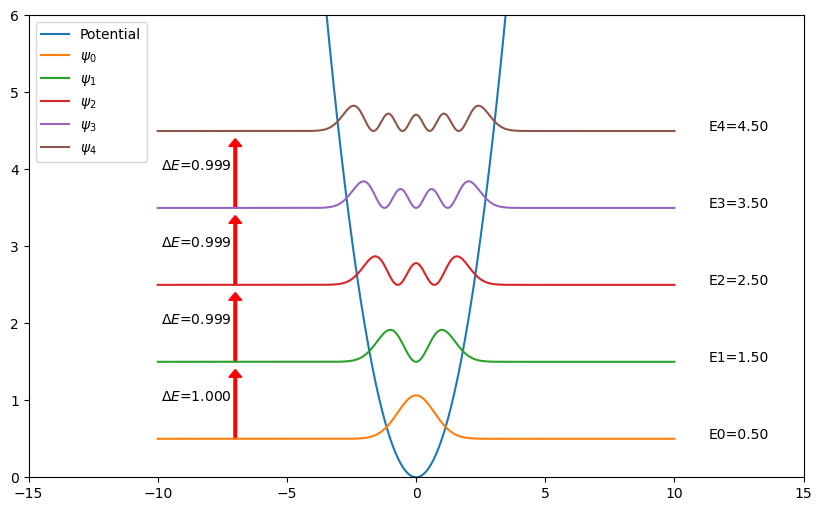

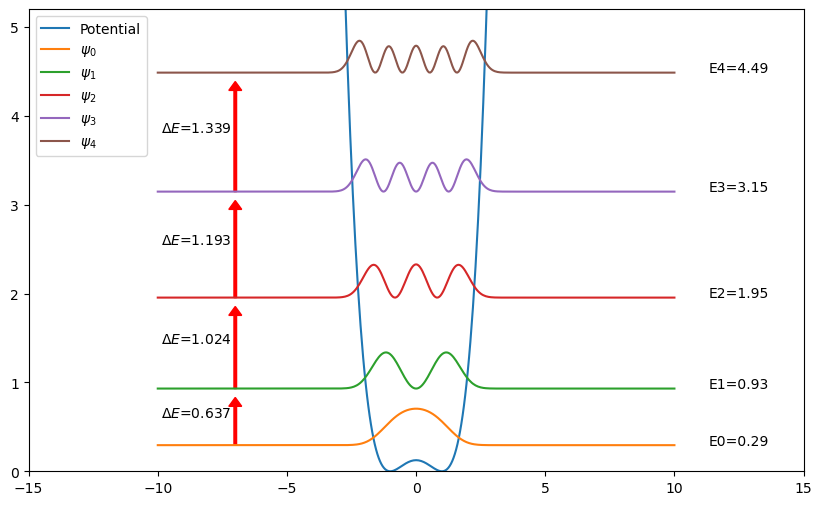

In [3]:
def plot_eigenstates(eps, psi, potential, x_lim=(-15,15), y_lim=(0,6)):
    n_eigensates = psi.shape[1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, potential, label="Potential")
    for i in range(n_eigenstates):
        plt.plot(x, np.abs(psi[:, i])**2 + eps[i], label=f"$\psi_{i}$")
        if i < n_eigenstates - 1:
            plt.arrow(-7,eps[i],0,eps[i+1]-eps[i]-0.2,head_width=0.5, head_length=0.1, edgecolor='red',facecolor='red', width=0.1)
            plt.annotate(r"$\Delta E$"+f"={(eps[i+1]-eps[i]):.3f}",xy=(-8.5,(eps[i]+eps[i+1])/2),horizontalalignment='center',fontsize=10)
        plt.annotate(f"E{i}={eps[i]:.2f}", xy=(12.5, eps[i]), horizontalalignment='center', fontsize=10)
    plt.legend(loc='upper left')
    plt.xlim(x_lim[0],x_lim[1])
    plt.ylim(y_lim[0],y_lim[1])
    plt.show()

n_x = 401
x_max = 10
x = np.linspace(-x_max, x_max, n_x)
dx = x[1] - x[0]

ho = harmonic_oscillator(x)
dw = double_well(x,a=1)
n_eigenstates = 5

hamiltonian_HO = Hamiltonian(x, ho)
eps_HO, psi_HO = hamiltonian_HO.get_eigenstates(n_eigenstates)

hamiltonian_dw = Hamiltonian(x, dw)
eps_dw, psi_dw = hamiltonian_dw.get_eigenstates(n_eigenstates)

plot_eigenstates(eps_HO, psi_HO, ho)
plot_eigenstates(eps_dw, psi_dw, dw, y_lim=(0,5.2))

# Time integration

Now, in order to solve the TDSE
\begin{align}
i \dot{\vec{\psi}}(x,t) &= H(x)\vec{\psi}(x, t), \\
\vec{\psi}(x,t_0) &= \vec{\psi}_0,
\end{align}
we have to discretize time.

For this we use the Crank-Nicolson (CN) method: https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method

\begin{align}
\left( I+\frac{i \Delta t}{2}H \right)\vec{\psi}(t+\Delta t) &= \left(I-\frac{i \Delta t}{2}H \right)\vec{\psi}(t), \\
\vec{\psi}(t+\Delta t) &= \left( I+\frac{i \Delta t}{2}H \right)^{-1}\left(I-\frac{i \Delta t}{2}H \right)\vec{\psi}(t)
\end{align}

* Pro: CN is stable and unitary
* Con: Have to solve linear equation in every time-step
* Implemented in "cranknicolson.py".
* A variety of other integrators are possible.


In [4]:
psi0 =  psi_HO[:,1].copy()
dt = 0.01
tfinal = 2*np.pi/eps_HO[1]
data = run_CN(hamiltonian_HO, psi0, x, dt, tfinal, psi_HO)

100%|████████████████████████████████████████| 418/418 [00:01<00:00, 374.99it/s]


In [5]:
psi_hist = data["psi_hist"]
time_points = data["time_points"]
num_steps = len(time_points)

fig, ax = plt.subplots()
line, = ax.plot(x, np.abs(psi_hist[0])**2, label=r'$|\Psi(x,t)|^2$')
line2, = ax.plot(x, psi_hist[0].real, label=r'$Re(\Psi(x,t))$')
line3, = ax.plot(x, psi_hist[0].imag, label=r'$Im(\Psi(x,t))$')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def update(frame):
    line.set_ydata(np.abs(psi_hist[10*frame])**2)
    line2.set_ydata(psi_hist[10*frame].real)
    line3.set_ydata(psi_hist[10*frame].imag)
    time_text.set_text(f'Time: {10*frame*dt:.2f}')
    return line, line2, line3, time_text

ani = animation.FuncAnimation(fig, update, frames=num_steps//10, interval=100, blit=True)
# Set y limit to 0.5
ax.set_xlim(-6,6)
ax.set_ylim(-1.1, 1.1)
ax.legend()
# Save as mp4 file
#ani.save('animation.mp4', writer='ffmpeg')
html = HTML(ani.to_jshtml())
display(html)
plt.close() # update

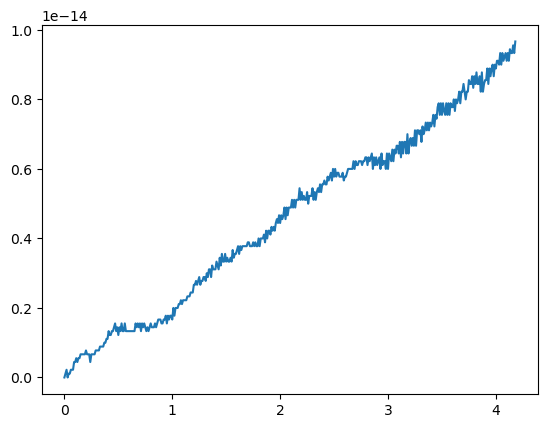

In [6]:
plt.figure()
plt.plot(time_points, 1-data["norm"].real)
plt.show()

In [7]:
psi0 = 1/np.sqrt(2)*(psi_HO[:,0]+psi_HO[:,1])

dt = 0.01
tfinal = 2*np.pi/(eps_HO[1]-eps_HO[0])
data = run_CN(hamiltonian_HO, psi0, x, dt, tfinal, psi_HO)

100%|████████████████████████████████████████| 628/628 [00:01<00:00, 329.29it/s]


In [8]:
psi_hist = data["psi_hist"]
time_points = data["time_points"]
num_steps = len(time_points)

fig, ax = plt.subplots()
line, = ax.plot(x, np.abs(psi_hist[0])**2, label=r'$|\Psi(x,t)|^2$')
line2, = ax.plot(x, np.abs(psi_HO[:,0])**2, label=r'$|\psi_0(x)|^2$')
line3, = ax.plot(x, np.abs(psi_HO[:,1])**2, label=r'$|\psi_1(x)|^2$')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def update(frame):
    line.set_ydata(np.abs(psi_hist[10*frame])**2)
    #line2.set_ydata(psi_hist[10*frame].real)
    #line3.set_ydata(psi_hist[10*frame].imag)
    time_text.set_text(f'Time: {10*frame*dt:.2f}')
    return line, time_text

ani = animation.FuncAnimation(fig, update, frames=num_steps//10, interval=100, blit=True)
# Set y limit to 0.5
ax.set_xlim(-6,6)
ax.set_ylim(-1.1, 1.1)
ax.legend()
# Save as mp4 file
#ani.save('animation.mp4', writer='ffmpeg')
html = HTML(ani.to_jshtml())
display(html)
plt.close() # update